# **MNIST Digits Classification using SGDRegressor**

## **Imports**

In [1]:
import numpy as np
from pprint import pprint

np.random.seed(42)

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

from scipy.stats import loguniform

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# global settings

mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)
mpl.rc('figure',figsize=(8,6))

# ignore all warnings
def warn(*args, **kwargs):
  pass
import warnings
warnings.warn=warn

In [2]:
from sklearn.datasets import fetch_openml
X_pd , y_pd=fetch_openml('mnist_784',version=1,return_X_y=True)

In [3]:
X=X_pd.to_numpy()
y=y_pd.to_numpy()

## **Pre-processing**

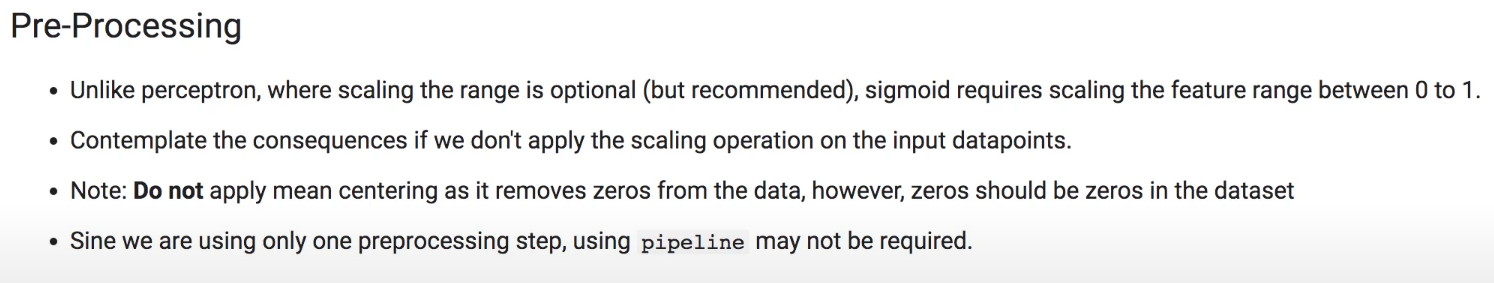

In [4]:
scaler=MinMaxScaler()
X=scaler.fit_transform(X)

In [5]:
print('Mean: ', np.mean(X))
print('Standard Dev: ', np.std(X))
print('Min: ', np.min(X))
print('Max: ', np.max(X))

Mean:  0.13092720382627604
Standard Dev:  0.3084510570135976
Min:  0.0
Max:  1.0


In [6]:
target_names=np.unique(y)
print('Number of samples: {0}, type:{1}'.format(X.shape[0],X.dtype))
print('Number of features:{0}'.format(X.shape[1]))
print('Number of classes"{0}, type: {1}'.format(len(target_names),y.dtype))
print('Labels: {0}'.format(target_names))

Number of samples: 70000, type:float64
Number of features:784
Number of classes"10, type: object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


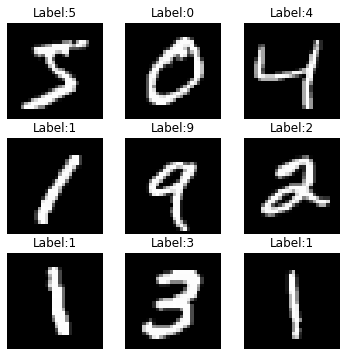

In [7]:
num_images=9
factor=np.int(np.sqrt(num_images))
fig, ax=plt.subplots(nrows=factor, ncols=factor, figsize=(6,6))
idx_offset=0
for i in range(factor):
  index=idx_offset+i*factor
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()

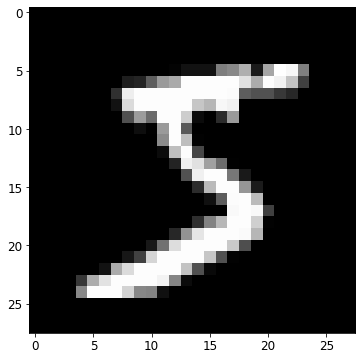

In [8]:
plt.figure(figsize=(6,6))
plt.imshow(X[0].reshape(28,28), cmap='gray')
plt.show()

## **Data Splitting**

In [9]:
x_train, x_test, y_train, y_test=X[:60000],X[60000:],y[:60000],y[60000:]

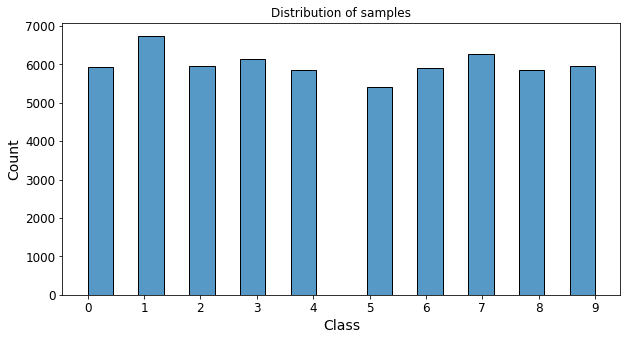

In [10]:
plt.figure(figsize=(10,5))
sns.histplot(data=np.int8(y_train),binwidth=0.45,bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

## **Binary classification : 0-detector**

In [11]:
y_train_0=np.zeros(len(y_train))
y_test_0=np.zeros(len(y_test))

indx_0=np.where(y_train=='0')
y_train_0[indx_0]=1
indx_0=np.where(y_test=='0')
y_test_0[indx_0]=1

In [12]:
print(y_train_0)
print(y_train)

[0. 1. 0. ... 0. 0. 0.]
['5' '0' '4' ... '5' '6' '8']


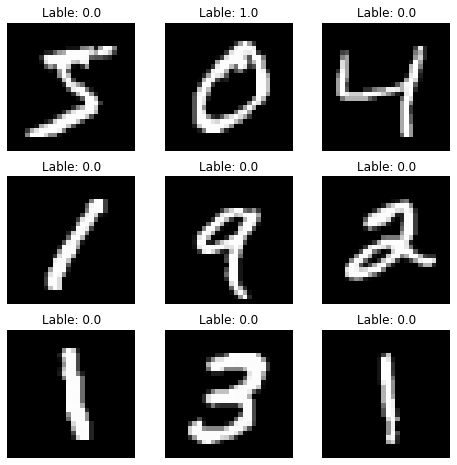

In [13]:
num_images=9
factor=int(np.sqrt(num_images))
fig,ax=plt.subplots(nrows=factor,ncols=factor, figsize=(8,8))
idx_offset=0
for i in range (factor):
  index=idx_offset+i*factor
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Lable: {0}'.format(str(y_train_0[index+j])))
    ax[i,j].set_axis_off()

## **Baseline model**

In [14]:
num_pos=len(np.where(y_train_0==1)[0])
num_neg=len(np.where(y_train_0==0)[0])
print(num_pos)
print(num_neg)

5923
54077


In [15]:
base_clf=DummyClassifier(strategy='most_frequent')
base_clf.fit(x_train,y_train_0)
print(base_clf.score(x_train,y_train_0))

0.9012833333333333


## **Logistic Regression Model**

In [16]:
bin_sgd_clf=SGDClassifier(loss='log',
                          penalty='l2',
                          warm_start=True,
                          max_iter=1,
                          eta0=0.01,
                          alpha=0,
                          learning_rate='constant',
                          random_state=1729)
Loss=[]
iterations=1000
for i in range(iterations):
  bin_sgd_clf.fit(x_train,y_train_0)
  y_pred=bin_sgd_clf.predict_proba(x_train)
  Loss.append(log_loss(y_train_0,y_pred))

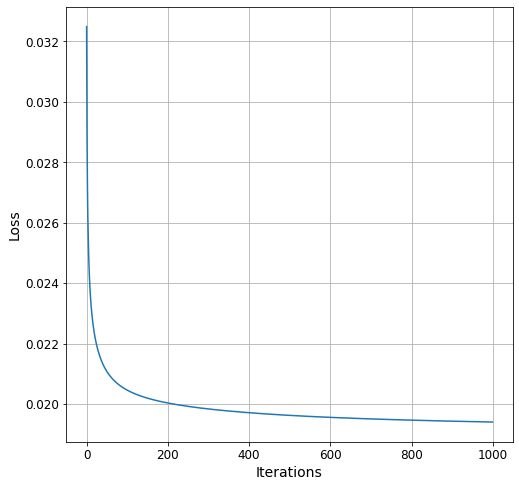

In [17]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(iterations),Loss)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [18]:
print('Training Accuracy: %.2f' %bin_sgd_clf.score(x_train,y_train_0))
print('Testing Accuracy: %.2f' %bin_sgd_clf.score(x_test, y_test_0))

Training Accuracy: 0.99
Testing Accuracy: 0.99


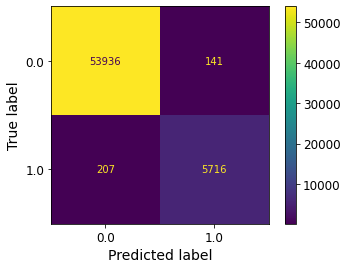

In [19]:
y_hat_train_0=bin_sgd_clf.predict(x_train)
cm_display=ConfusionMatrixDisplay.from_predictions(y_train_0,
                                                   y_hat_train_0, 
                                                   values_format='.5g')
plt.show()

In [20]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54077
         1.0       0.98      0.97      0.97      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



In [21]:
estimator=SGDClassifier(loss='log',
                        penalty='l2',
                        max_iter=100,
                        warm_start=False,
                        eta0=0.01,
                        alpha=0,
                        learning_rate='constant',
                        random_state=1729)

In [22]:
cv_bin_clf=cross_validate(estimator,x_train,y_train_0,cv=5,
                          scoring=['precision','recall','f1'],
                          return_train_score=True,
                          return_estimator=True)
pprint(cv_bin_clf)

{'estimator': [SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729)],
 'fit_time': array([1.2648201 , 1.21085191, 1.21027422, 1.31636786, 1.09373498]),
 'score_time': array([0.0386529 , 0.03553605, 0.0362792 , 0.04492044, 0.03786159]),
 'test_f1': array([0.95699831, 0.954371  , 0.9616041 , 0.95870583, 0.95993252]),
 'test_precision': array([0.95538721, 0.96382429, 0.97238999, 0.96735395, 0.9

In [23]:
weights=bin_sgd_clf.coef_
bias=bin_sgd_clf.intercept_
print('Dimentions of weights:{0}'.format(weights.shape))
print('Dimentions of bias:{0}, bias:{1}'.format(bias.shape,bias))

Dimentions of weights:(1, 784)
Dimentions of bias:(1,), bias:[-5.19057844]


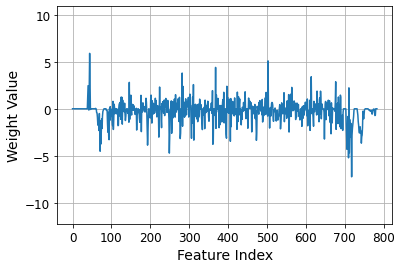

In [24]:
plt.figure()
plt.plot(np.arange(0,784),weights[0,:])
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.ylim((np.min(weights)-5),np.max(weights)+5)
plt.grid()

In [25]:
num_zero_w=weights.shape[1]-np.count_nonzero(weights)
print('Number of weights with value 0 are:',num_zero_w)

Number of weights with value 0 are: 67


## **Training with Regularization**

In [26]:
bin_sgd_clf_l2=SGDClassifier(
    loss='log',
    penalty='l2',
    alpha=0.001,
    max_iter=1,
    eta0=0.01,
    warm_start=True,
    learning_rate='constant',
    random_state=1729
)
Loss=[]
iterations=100
for i in range(iterations):
  bin_sgd_clf_l2.fit(x_train,y_train_0)
  y_pred=bin_sgd_clf_l2.predict_proba(x_train)
  Loss.append(log_loss(y_train_0,y_pred))

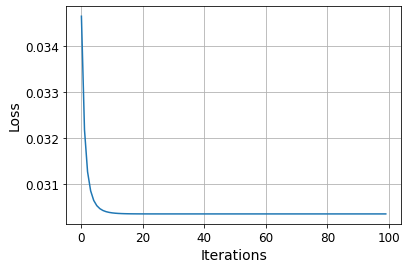

In [27]:
plt.figure()
plt.plot(np.arange(iterations),Loss)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [28]:
weights=bin_sgd_clf_l2.coef_
bias=bin_sgd_clf_l2.intercept_
print(weights.shape, bias.shape, bias)

(1, 784) (1,) [-4.43002876]


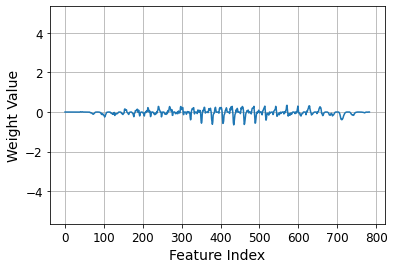

In [29]:
plt.figure()
plt.plot(np.arange(0,784),weights[0,:])
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.ylim((np.min(weights)-5),(np.max(weights)+5))
plt.grid()
plt.show()

In [30]:
num_zero_w=weights.shape[1]-np.count_nonzero(weights)
num_zero_w

67

In [31]:
print('Training accuracy %.2f'%bin_sgd_clf_l2.score(x_train,y_train_0))
print('Test accuracy %.2f'%bin_sgd_clf_l2.score(x_test,y_test_0))

Training accuracy 0.99
Test accuracy 0.99


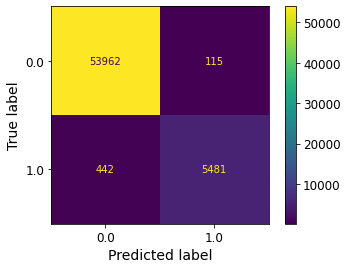

In [32]:
y_hat_train_0=bin_sgd_clf_l2.predict(x_train)
cm_display=ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0,values_format='.5g')
plt.show()

In [33]:
print(classification_report(y_train_0,y_hat_train_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



## **Displaying Input Image and its Prediction**

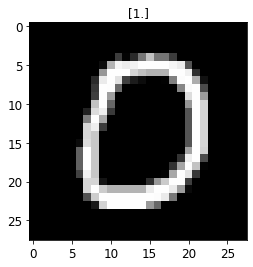

In [34]:
index=10
plt.imshow(x_test[index,:].reshape(28,28),cmap='gray')
pred=bin_sgd_clf.predict(x_test[index].reshape(1,-1))
plt.title(str(pred))
plt.show()

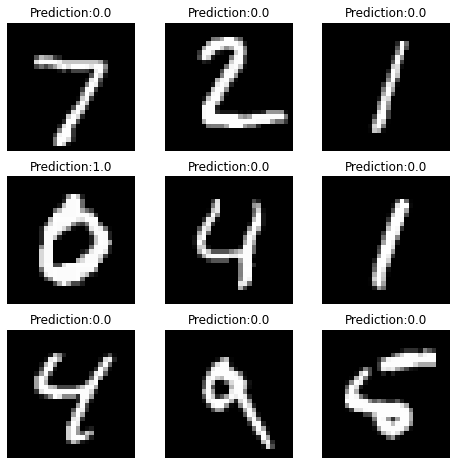

In [35]:
y_hat_test_0=bin_sgd_clf.predict(x_test)
num_images=9
factor=int(np.sqrt(num_images))
fig, ax=plt.subplots(nrows=factor,ncols=factor,figsize=(8,8))
idx_offset=0
for i in range(factor):
  index=idx_offset+i*factor
  for j in range(factor):
    ax[i,j].imshow(x_test[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Prediction:{0}'.format(str(y_hat_test_0[index+j])))
    ax[i,j].set_axis_off()

In [36]:
indx_0=np.where(y_test_0==1)

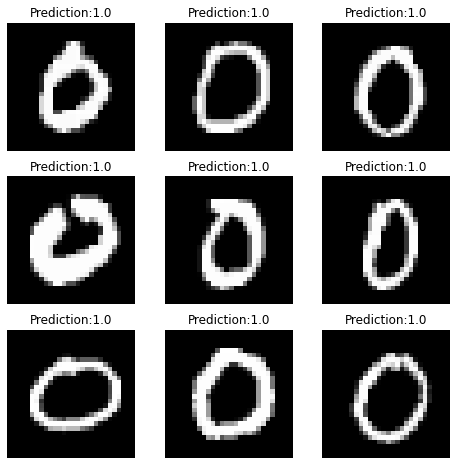

In [37]:
zeroImgs=x_test[indx_0[0]]
zeroLabels=y_hat_test_0[indx_0[0]]
num_images=9
factor=int(np.sqrt(num_images))
fig, ax=plt.subplots(nrows=factor,ncols=factor,figsize=(8,8))
idx_offset=0
for i in range(factor):
  index=idx_offset+i*factor
  for j in range(factor):
    ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Prediction:{0}'.format(str(zeroLabels[index+j])))
    ax[i,j].set_axis_off()

## **Hyper Parameter Tuning**

In [38]:
lr_grid=loguniform(1e-2,1e-1)

In [39]:
print(lr_grid.rvs(3,random_state=42))

[0.02368864 0.0892718  0.05395031]


In [40]:
estimator=SGDClassifier(loss='log',
                        max_iter=1,
                        penalty='l2',
                        warm_start=True,
                        eta0=0.01,
                        alpha=0,
                        learning_rate='constant',
                        random_state=1729)

In [41]:
scores=RandomizedSearchCV(estimator,
                          param_distributions={'eta0':lr_grid},
                          cv=5,
                          scoring=['precision','recall','f1'],
                          n_iter=5,
                          refit='f1')

In [42]:
scores.fit(x_train,y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(alpha=0, eta0=0.01,
                                           learning_rate='constant', loss='log',
                                           max_iter=1, random_state=1729,
                                           warm_start=True),
                   n_iter=5,
                   param_distributions={'eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f76bb288950>},
                   refit='f1', scoring=['precision', 'recall', 'f1'])

In [43]:
pprint(scores.cv_results_)

{'mean_fit_time': array([0.28162055, 0.27826428, 0.28043933, 0.27723136, 0.2776526 ]),
 'mean_score_time': array([0.03601465, 0.03634858, 0.03770304, 0.03573589, 0.03561425]),
 'mean_test_f1': array([0.95383975, 0.94148246, 0.94869555, 0.95090017, 0.95474878]),
 'mean_test_precision': array([0.96136672, 0.93597638, 0.94998271, 0.9540212 , 0.96640269]),
 'mean_test_recall': array([0.94682062, 0.94851138, 0.94834146, 0.94850966, 0.94361173]),
 'param_eta0': masked_array(data=[0.02368863950364078, 0.08927180304353625,
                   0.05395030966670228, 0.039687933304443715,
                   0.01432249371823025],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'eta0': 0.02368863950364078},
            {'eta0': 0.08927180304353625},
            {'eta0': 0.05395030966670228},
            {'eta0': 0.039687933304443715},
            {'eta0': 0.01432249371823025}],
 'rank_test_f1': array([2, 5, 4, 3, 1], dtype=int32),


In [44]:
best_bin_clf=scores.best_estimator_

In [45]:
y_hat_train_best_0=best_bin_clf.predict(x_train)

In [46]:
print(classification_report(y_train_0, y_hat_train_best_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.92      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



## **Classification Report**

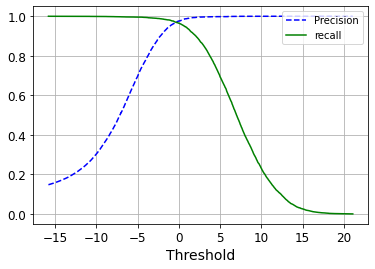

In [47]:
y_scores=bin_sgd_clf.decision_function(x_train)
precisions, recalls, thresholds=precision_recall_curve(y_train_0,y_scores)
plt.figure()
plt.plot(thresholds,precisions[:-1],'b--',label='Precision')
plt.plot(thresholds,recalls[:-1],'g-',label='recall')
plt.xlabel('Threshold')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

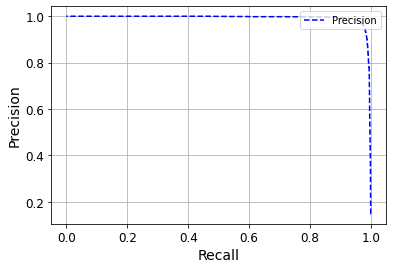

In [48]:
plt.figure()
plt.plot(recalls[:-1],precisions[:-1],'b--',label='Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

## **ROC Curve**

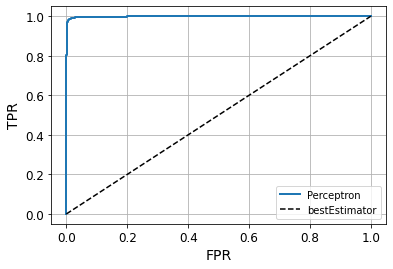

In [49]:
fpr, tpr, thresholds=roc_curve(y_train_0, y_scores)
plt.figure()
plt.plot(fpr,tpr,linewidth=2,label='Perceptron')
plt.plot([0,1],[0,1],'k--',label='bestEstimator')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid(True)
plt.legend()
plt.show()

In [50]:
auc=roc_auc_score(y_train_0,y_scores)
auc

0.9986982188225544

# **MNIST Digits Classification using Logistic Regression**

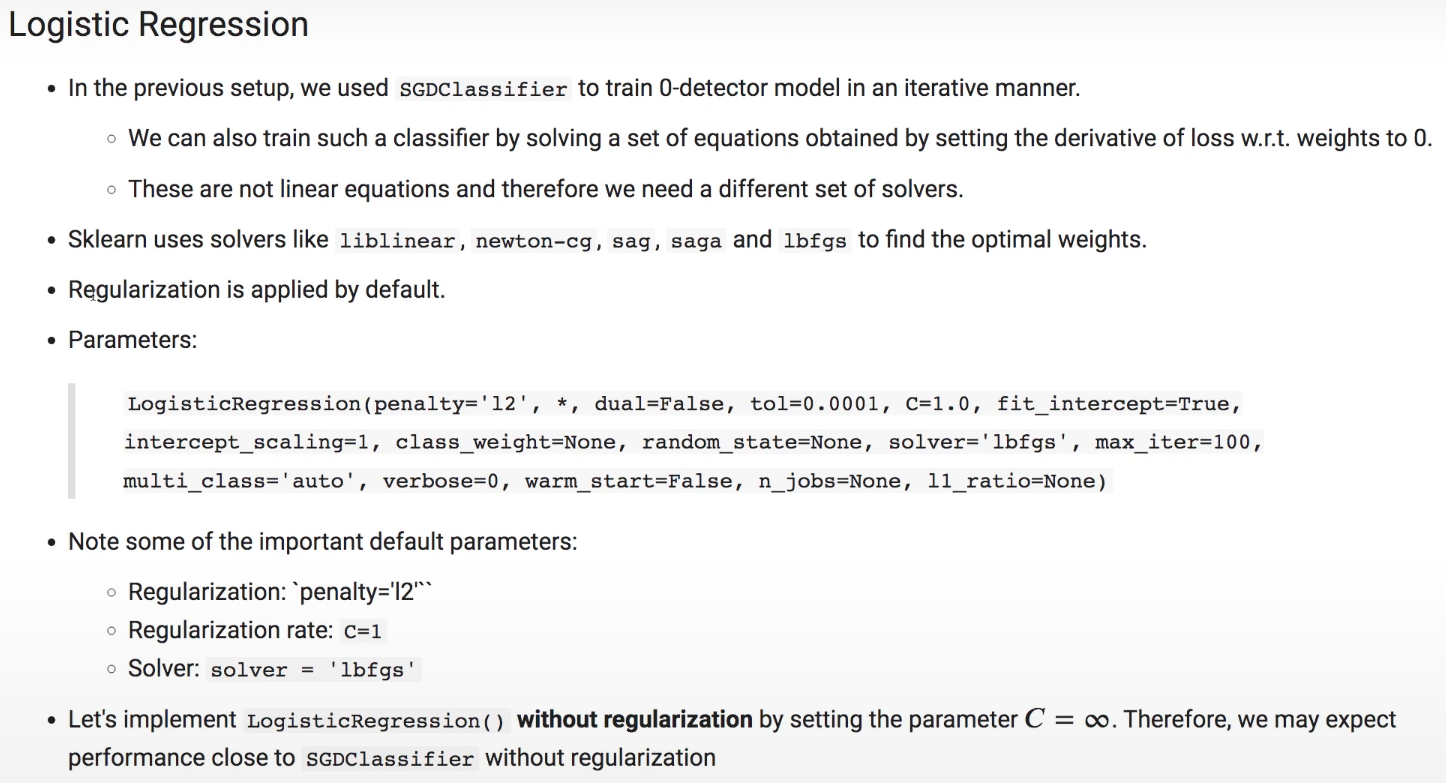

## **Training Without Regularization**

In [51]:
pipe_logit=make_pipeline(MinMaxScaler(),
                         LogisticRegression(random_state=1729,
                                             solver='lbfgs',
                                             C=np.infty))
pipe_logit.fit(x_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

## **Hyperparameter Search**

### **With GridsearchCV**

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
grid_Cs=[0,1e-4,1e-3,1e-2,1e-1,1.0,10.0,100.0]

scaler=MinMaxScaler()
logreg=LogisticRegression(C=1.0,random_state=1729)

pipe=Pipeline(steps=[("scaler",scaler),
              ('logreg',logreg)])

pipe_logit_cv=GridSearchCV(
    pipe,
    param_grid={'logreg__C':grid_Cs},
    scoring='f1'
)
pipe_logit_cv.fit(x_train,y_train_0)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logreg',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logreg__C': [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                       100.0]},
             scoring='f1')

In [53]:
pipe_logit_cv.best_params_

{'logreg__C': 0.1}

In [54]:
pipe_logit_cv.best_score_

0.9579654953103655

In [55]:
pipe_logit_cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logreg', LogisticRegression(C=0.1, random_state=1729))])

### **With LogisticRegressionCV**

In [56]:
from sklearn.linear_model import LogisticRegressionCV
estimator=LogisticRegressionCV(cv=5,
                               scoring='f1',
                               random_state=1729)
logit_cv=make_pipeline(MinMaxScaler(),estimator)
logit_cv.fit(x_train,y_train_0)

KeyboardInterrupt: ignored

## **Performance Evaluation**

In [ ]:
lr_y_hat_0=pipe_logit.predict(x_test)
lr_gs_y_hat_0=pipe_logit_cv.best_estimator_.predict(x_test)
lr_cv_y_hat_0=logit_cv.predict(x_test)

In [ ]:
precision_lr=precision_score(y_test_0,lr_y_hat_0)
recall_lr=recall_score(y_test_0,lr_y_hat_0)

precision_lr_gs=precision_score(y_test_0,lr_gs_y_hat_0)
recall_lr_gs=recall_score(y_test_0,lr_gs_y_hat_0)

precision_lr_cv=precision_score(y_test_0,lr_cv_y_hat_0)
recall_lr_cv=recall_score(y_test_0,lr_cv_y_hat_0)

In [ ]:
print(f"LogReg: precision={precision_lr}, recall={recall_lr}")
print(f"GridSearchCV: precision={precision_lr_gs}, recall={recall_lr_gs}")
print(f"LogRegCV: precision={precision_lr_cv}, recall={recall_lr_cv}")

## **Using PR Curve**

In [ ]:
y_scores_lr=pipe_logit.decision_function(x_test)
precisions_lr,recalls_lr, threholds_lr=precision_recall_curve(
    y_test_0, y_scores_lr
)

y_scores_lr_gs=pipe_logit_cv.decision_function(x_test)
precisions_lr_gs,recalls_lr_gs, threholds_lr_gs=precision_recall_curve(
    y_test_0, y_scores_lr_gs
)

y_scores_lr_cv=logit_cv.decision_function(x_test)
precisions_lr_cv,recalls_lr_cv, threholds_lr_cv=precision_recall_curve(
    y_test_0, y_scores_lr_cv
)

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(recalls_lr[:-1],precisions_lr[:-1],'b--',label='LogReg')
plt.plot(recalls_lr_gs[:-1],precisions_lr_gs[:-1],'r--',label='GridSearchCV')
plt.plot(recalls_lr_cv[:-1],precisions_lr_cv[:-1],'g--',label='LogReg CV')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import auc

auc_lr=auc(recalls_lr[:-1],precisions_lr[:-1])
auc_lr_gs=auc(recalls_lr_gs[:-1],precisions_lr_gs[:-1])
auc_lr_cv=auc(recalls_lr_cv[:-1],precisions_lr_cv[:-1])

## **Confusion Matrix**

In [ ]:
cm_display=ConfusionMatrixDisplay.from_predictions(y_test_0, lr_y_hat_0,values_format='.5g')
plt.show()

In [ ]:
cm_display=ConfusionMatrixDisplay.from_predictions(y_test_0, lr_gs_y_hat_0,values_format='.5g')
plt.show()

In [ ]:
cm_display=ConfusionMatrixDisplay.from_predictions(y_test_0, lr_cv_y_hat_0,values_format='.5g')
plt.show()

# **Zero detector with Ridge Classifier**

In [ ]:
y_train_0=-1*np.ones((len(y_train)))
y_test_0=-1*np.ones(len(y_test))

indx_0=np.where(y_train=='0')
y_train_0[indx_0]=1
indx_0=np.where(y_test=='0')
y_test_0[indx_0]=1

In [ ]:
estimator=RidgeClassifier(normalize=False,
                          alpha=0)
pipe_ridge=make_pipeline(MinMaxScaler(),estimator)
pipe_ridge.fit(x_train,y_train_0)

In [ ]:
y_hat_train_0=pipe_ridge.predict(x_test)
print(classification_report(y_test_0,y_hat_train_0))

## **Cross validation**

In [ ]:
cv_bin_ridge_clf=cross_validate(
    pipe_ridge, x_train, y_train_0, cv=5,
    scoring=['precision','recall','f1'],
    return_train_score=True,
    return_estimator=True
)
pprint(cv_bin_ridge_clf)

In [ ]:
best_estimator_id=np.argmax(cv_bin_ridge_clf['train_f1']);best_estimator_id

In [ ]:
best_estimator=cv_bin_ridge_clf['estimator'][best_estimator_id]

In [ ]:
y_hat_test_0=best_estimator.predict(x_test)
print(classification_report(y_test_0,y_hat_test_0))

## **Future Exploration**

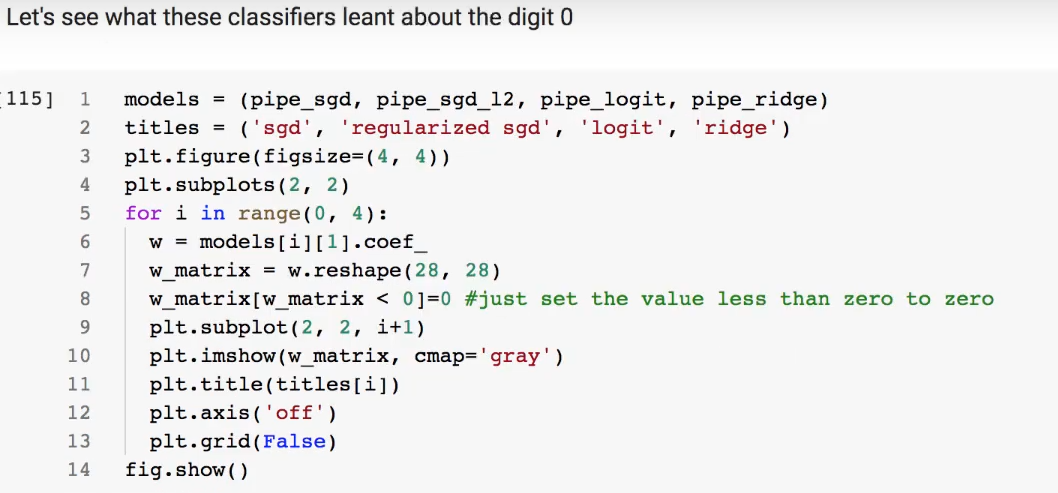

In [ ]:
# models=(pipe_sgd,pipe_sgd_l2,pipe_logit,pipe_ridge)
# titles=('sgd','regularized sgd','logit','ridge')


# **Multiclass classifier on MNIST Dataset**

## **Multiclass Logit with SGD**

In [ ]:
estimator=SGDClassifier(loss='log',
                        penalty='l2',
                        max_iter=1,
                        warm_start=True,
                        eta0=0.01,
                        alpha=0,
                        learning_rate='constant',
                        random_state=1729)
pipe_sgd_ovr=make_pipeline(MinMaxScaler(),estimator)

In [ ]:
Loss=[]
iterations=100
for i in range(iterations):
  pipe_sgd_ovr.fit(x_train, y_train)
  y_pred=pipe_sgd_ovr.predict_proba(x_train)
  Loss.append(log_loss(y_train,y_pred))

In [ ]:
plt.figure()
plt.plot(np.arange(iterations),Loss)
plt.grid(True)
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.show()

In [ ]:
pipe_sgd_ovr[1]

In [ ]:
pipe_sgd_ovr[1].coef_.shape

In [ ]:
y_hat=pipe_sgd_ovr.predict(x_test)
y_hat[:5]

In [ ]:
cm_display=ConfusionMatrixDisplay.from_predictions(y_test,y_hat)

In [ ]:
print(classification_report(y_test,y_hat))

## **Multiclass Logistic Regression using solvers**

In [ ]:
pipe_logit_ovr=make_pipeline(MinMaxScaler(),
                             LogisticRegression(random_state=1729,
                                                solver='lbfgs',
                                                C=np.infty))
pipe_logit_ovr.fit(x_train,y_train)

In [ ]:
y_hat=pipe_logit_ovr.predict(x_test)
cm_display=ConfusionMatrixDisplay.from_predictions(y_test, y_hat)


In [ ]:
print(classification_report(y_test,y_hat))

## **Visualize Weight Values**

In [ ]:
W=pipe_logit_ovr[1].coef_
W=MinMaxScaler().fit_transform(W)
fig,ax=plt.subplots(3,3)
index=1

for i in range(3):
  for j in range(3):
    ax[i][j].imshow(W[index,:].reshape(28,28),cmap='gray')
    ax[i][j].set_title('W{0}'.format(index))
    ax[i][j].set_axis_off()
    index=index+1

# **Naive Bayes Classifier**

## **Imports and basics**

In [154]:
from sklearn.datasets import fetch_20newsgroups

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [155]:
data=fetch_20newsgroups()

In [156]:
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [157]:
categories=['talk.religion.misc','soc.religion.christian','sci.space','comp.graphics']

In [158]:
train=fetch_20newsgroups(subset='train',categories=categories)
test=fetch_20newsgroups(subset='test',categories=categories)

In [159]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



## **Data preprocessing and modeling**

In [160]:
model=make_pipeline(TfidfVectorizer(),MultinomialNB())

In [161]:
model.fit(train.data,train.target)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

## **Model evaluation**

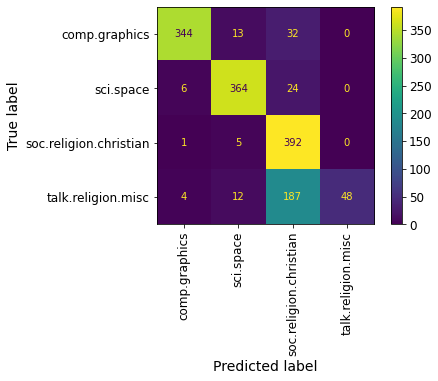

In [162]:
ConfusionMatrixDisplay.from_estimator(model, test.data, test.target,
                             display_labels=test.target_names,
                             xticks_rotation='vertical')
plt.show()

In [163]:
def predict_category(s, train=train, model=model):
  pred=model.predict([s])
  return train.target_names[pred[0]]

In [164]:
predict_category('sending a payload to the ISS')

'sci.space'

In [165]:
predict_category('discussing islam vs aethism')

'soc.religion.christian'

In [166]:
predict_category('Screen resolution')

'comp.graphics'

# **Practice Assignment**

In [57]:
np.random.seed(42)

from sklearn.datasets import fetch_openml
X_pd , y_pd=fetch_openml('mnist_784',version=1,return_X_y=True)

X=X_pd.to_numpy()
y=y_pd.to_numpy()

In [96]:
xsize=X.shape
xsize

(70000, 784)

In [97]:
xsize[0]*0.7

49000.0

In [98]:
x_train, x_test, y_train, y_test=X[:49000],X[49000:],y[:49000],y[49000:]

In [99]:
y_train[-1]

'6'

In [100]:
y_train[:10]

array(['5', '0', '4', '1', '9', '2', '1', '3', '1', '4'], dtype=object)

In [101]:
indx_6=np.where(y_train=='6')
indx_6

(array([   13,    18,    32, ..., 48958, 48994, 48999]),)

In [102]:
train_filter6 = np.where((y_train == '6' ) )
train_filter9 = np.where((y_train == '9'))
test_filter6 = np.where((y_test == '6') )
test_filter9 = np.where((y_test == '9'))

x_train_6, y_train_6 = x_train[train_filter6], y_train[train_filter6]
x_test_6, y_test_6 = x_test[test_filter6], y_test[test_filter6]

x_train_9, y_train_9 = x_train[train_filter9], y_train[train_filter9]
x_test_9, y_test_9 = x_test[test_filter9], y_test[test_filter9]

In [103]:
x_train_69=np.concatenate((x_train_6,x_train_9))
y_train_69=np.concatenate((y_train_6,y_train_9))
x_test_69=np.concatenate((x_test_6,x_test_9))
y_test_69=np.concatenate((y_test_6,y_test_9))

In [104]:
y_train_69

array(['6', '6', '6', ..., '9', '9', '9'], dtype=object)

In [106]:
y_train_6.shape

(4855,)

In [107]:
y_train_69_final=np.zeros(len(y_train_69))
y_test_69_final=np.zeros(len(y_test_69))

indx_0=np.where(y_train_69=='6')
y_train_69_final[indx_0]=1
indx_0=np.where(y_test_69=='6')
y_test_69_final[indx_0]=1

In [108]:
y_train_69_final

array([1., 1., 1., ..., 0., 0., 0.])

In [109]:
from sklearn.utils import shuffle

In [111]:
y_test_6.shape

(2021,)

In [113]:
x_train_69=shuffle(x_train_69,random_state=1729)

In [114]:
x_test_69=shuffle(x_test_69,random_state=1729)

In [115]:
y_train_69_final=shuffle(y_train_69_final,random_state=1729)

In [116]:
y_test_69_final=shuffle(y_test_69_final,random_state=1729)

In [118]:
y_train_69_final

array([1., 0., 1., ..., 1., 1., 1.])

In [127]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train_69)
x_train_69Tf=scaler.transform(x_train_69)

In [130]:
x_train_69Tf[0].mean()

0.08128379559427823

In [132]:
np.mean(x_train_69Tf, axis=0)[0]

0.0

In [133]:
np.std(x_train_69Tf, axis=0)[0]

0.0

In [134]:
np.std(x_train_69Tf, axis=1)[0]

0.7358823226037738

In [149]:
bin_sgd_clf=SGDClassifier(loss='log',
                          penalty='l2',
                          warm_start=True,
                          max_iter=1,
                          eta0=0.01,
                          alpha=0,
                          learning_rate='constant',
                          random_state=10)
Loss=[]
iterations=30
for i in range(iterations):
  bin_sgd_clf.fit(x_train_69,y_train_69_final)
  y_pred=bin_sgd_clf.predict_proba(x_train_69)
  Loss.append(log_loss(y_train_69_final,y_pred))

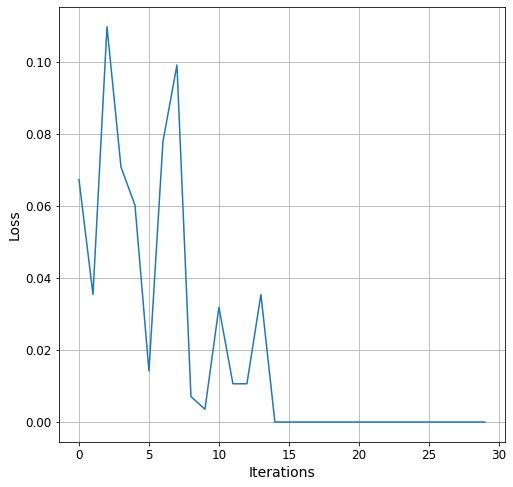

In [150]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(iterations),Loss)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [153]:
bin_sgd_clf=SGDClassifier(
    # loss='log',
                          power_t = 0.5,
                          # penalty='l2',
                          # warm_start=True,
                          max_iter=1,
                          eta0=0.5,
                          alpha=0,
                          learning_rate='inv_scaling',
                          shuffle = True,
                          random_state=10)
Loss=[]
iterations=10
for i in range(iterations):
  bin_sgd_clf.fit(x_train_69,y_train_69_final)
  y_pred=bin_sgd_clf.predict_proba(x_train_69)
  Loss.append(log_loss(y_train_69_final,y_pred))

plt.figure(figsize=(8,8))
plt.plot(np.arange(iterations),Loss)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

ValueError: ignored

In [167]:
from sklearn.datasets import fetch_20newsgroups

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

data=fetch_20newsgroups()

In [182]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train)

In [181]:
train=fetch_20newsgroups(subset='train')
test=fetch_20newsgroups(subset='test')

In [184]:
X.shape

(5, 5)